In [6]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
import datasets.seq_mnist 
reload(datasets.seq_mnist)
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from tqdm import tqdm
import yaml
from utils import yaml_utils as yu

seed = 1234

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1
    
def load_config(path):
    with open(path, 'r') as f:
        config = yaml.safe_load(f)
    return config 

def load_model(model, log_dir, iters):
    model.load_state_dict(torch.load(os.path.join(
        log_dir, 'snapshot_model_iter_{}'.format(iters)), map_location=device))

def load_dataset(dataset_name, train):
    rng = np.random.RandomState(seed)
    if dataset_name == 'mnist':
        T = 10
        data = SequentialMNIST(
            datadir_root, train, T=T, max_angle_velocity_ratio=[-0.2, 0.2],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=False,
            rng=rng)
        block_dim_list = [[1, 15, 8, 14], [2, 13,10,11],[4,6,5,12]]
    elif dataset_name == 'mnist_bg':
        T = 10
        data = SequentialMNIST(
            datadir_root, train, T=T, max_angle_velocity_ratio=[-0.2, 0.2],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=True,
            backgrnd=True,
            rng=rng)
        block_dim_list =  [[6,7],[10, 13], [4,9,1, 14, 15]]
    elif dataset_name == 'mnist_bg_full':
        T = 10
        data = SequentialMNIST(
            datadir_root, train, T=T, max_angle_velocity_ratio=[-0.2, 0.2],
            max_color_velocity_ratio=[-0.2, 0.2],
            max_pos=[-10, 10],
            max_T=T,
            only_use_digit4=False,
            backgrnd=True,
            rng=rng)
        block_dim_list = [[9, 13, 6, 15], [1, 4],[2,7,11]] 
    elif dataset_name == '3dshapes':
        T = 8
        data = ThreeDimShapesDataset(
            root=datadir_root,
            train=True, T=T,
            rng=rng)
        block_dim_list = [[6,15],[4,7,8,11], [1,12], [0, 2, 5, 13], [9, 10, 3, 14]]
    elif dataset_name == 'smallNORB':
        T = 6
        data = SmallNORBDataset(
            root=datadir_root,
            train=train,
            T=T,
            rng=rng)
        block_dim_list = [[12,13,5,8,9,10],[7, 14,15,3, 6, 0,1,2]]
    else:
        raise NotImplementedError
    return data, block_dim_list
        

# Load a pretrained model

In [7]:
# PATH TO THE ROOTs OF DATASETS DIRECTORIES AND LOG DIRECTORIES
datadir_root = '/path/to/dataset_root/' 
logdir = '/path/to/model/'
config = load_config(os.path.join(logdir, 'config.yml'))
model = yu.load_component(config['model'])
model.to(device)
load_model(model, logdir, iters=config['max_iteration'])
model.eval()
print('Loaded model')

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Loaded model


In [8]:
from utils. optimize_bd_cob import optimize_bd_cob
dataset_name = 'mnist_bg_full' #['mnist', 'mnist_bg','mnist_bg_full', '3dshapes', 'smallNORB']
train_data, block_dim_list = load_dataset(dataset_name, True)
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
train_loader = DataLoader(train_data, 32, True, num_workers=0)
results={}
Ms = []
count = 0
with torch.no_grad():
    for images in tqdm(train_loader):
        images = torch.stack(images).transpose(1,0)
        images = images.to(device)  
        Ms.append(model.get_M(images).detach())
        count += 1
        if count > 100:
            break
Ms = torch.cat(Ms, axis=0)
CofB = optimize_bd_cob(Ms, n_epochs=50)



                  background ON
                  


  5%|▌         | 100/1875 [00:18<05:24,  5.47it/s]


ep:9 loss:4.69878078215193
ep:19 loss:4.691385920685117
ep:29 loss:4.687953703474291
ep:39 loss:4.684454766830595
ep:49 loss:4.684438743213616


mkdir: cannot create directory ‘figs’: File exists


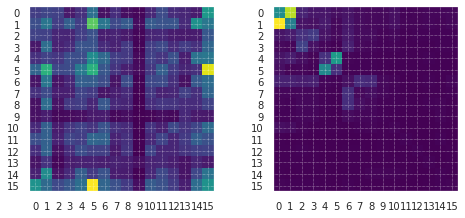

In [9]:
!mkdir figs
model.change_of_basis = torch.nn.Parameter(torch.eye(model.dim_a).to(device))
Vs = CofB(Ms) # V = UMU^{-1}
#block_dim_list = [list(np.arange(0, model.dim_a))]

order = [] 
for ind in block_dim_list:
    order += ind
order = order + list(set(np.arange(model.dim_a)) - set(order))

import seaborn as sns
sns.set_theme()
mean_Ms = torch.mean(torch.abs(torch.eye(model.dim_a).to(device)[None] - Ms), axis=0)
mean_Vs= torch.mean(torch.abs(torch.eye(model.dim_a).to(device)[None] - Vs), axis=0)[order][:, order]
plt.figure(figsize=[8, 3.4])

plt.subplot(1, 2, 1)
plt.imshow(mean_Ms.detach().cpu().numpy().T, cmap="viridis")
#plt.title('$\mathbb{E}[abs(\mathbf{M})]$',fontsize=20)
plt.xticks(np.arange(model.dim_a), fontsize=10.0)
plt.yticks(np.arange(model.dim_a), fontsize=10.0)
plt.grid(color='w', linestyle=':', linewidth=0.5)
plt.subplot(1, 2, 2)
plt.imshow(mean_Vs.detach().cpu().numpy().T, cmap="viridis")
#plt.title('$\mathbb{E}[abs(\mathbf{U^{-1}MU})]$',fontsize=20)
plt.xticks(np.arange(model.dim_a), fontsize=10.0)
plt.yticks(np.arange(model.dim_a), fontsize=10.0)
plt.grid(color='w', linestyle=':', linewidth=0.5)
plt.savefig('figs/sbd_{}.pdf'.format(dataset_name))

  0%|          | 10/6000 [00:00<06:06, 16.35it/s]


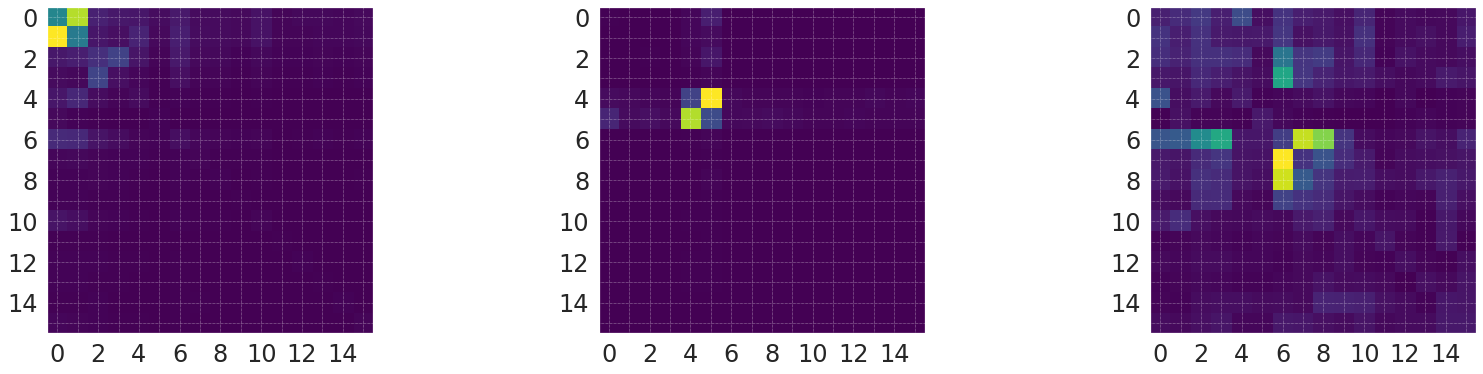

In [10]:
fig = plt.figure(figsize=[28, 6])
#train_data = load_dataset(dataset_name, True)

for i, action_index in enumerate(train_data.default_active_actions):
    train_data.active_actions = [action_index,]
    train_loader = DataLoader(train_data, 10, True, num_workers=0)
    results={}
    Ms_i = []
    count = 0
    with torch.no_grad():
        for images in tqdm(train_loader):
            images = torch.stack(images).transpose(1,0)
            images = images.to(device)
            Ms_i.append(model.get_M(images).detach())
            count += 1
            if count > 10:
                break

    Vs_i = CofB(torch.cat(Ms_i, axis=0))
    mean_Vs_i = torch.mean(torch.abs(torch.eye(model.dim_a).to(device)[None] - Vs_i), axis=0)[order][:, order]

    ax = fig.add_subplot(1, len(train_data.default_active_actions), i + 1)
    ax.imshow(mean_Vs_i.detach().cpu().numpy().T, cmap="viridis")
    ax.set_xticks(np.arange(0, model.dim_a, 2), fontsize=30.0)
    ax.set_xticks(np.arange(model.dim_a), fontsize=30.0, minor=True)
    ax.set_yticks(np.arange(0, model.dim_a, 2), fontsize=30.0)
    ax.set_yticks(np.arange(model.dim_a), fontsize=30.0, minor=True)
    ax.tick_params(axis='both', which='major', labelsize=24)
    ax.grid(which='minor', color='w', linestyle=':', linewidth=0.5)
    ax.grid(which='major', color='w', linestyle=':', linewidth=0.5)
plt.savefig('figs/sbd_{}_components.pdf'.format(dataset_name, action_index))

In [11]:
model.change_of_basis = torch.nn.Parameter(CofB.U)
test_data, block_dim_list = load_dataset(dataset_name, False)
test_data.force_moving=True

test_loader = DataLoader(test_data, 8, True, num_workers=0)


                  background ON
                  


In [12]:
images = iter(test_loader).next()
images = torch.stack(images).transpose(1,0)
images = images.to(device)

In [13]:
fix_indices=None
n_cond = 2
n_rolls = test_data.T - n_cond
images_cond = images[:, :n_cond]
model.eval()
images_pred_org = model(images_cond, n_rolls=n_rolls, fix_indices=fix_indices)

[6, 15]
[4, 7, 8, 11]
[1, 12]
[0, 2, 5, 13]
[9, 10, 3, 14]


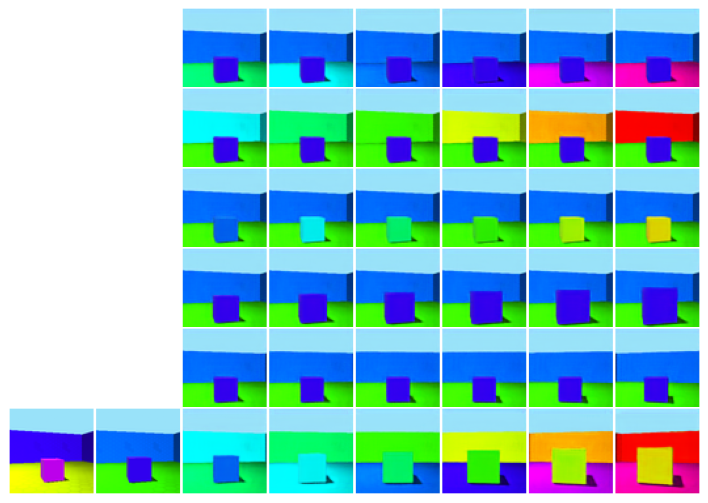

In [97]:
k = 0
n_actions = len(test_data.default_active_actions)
plt.figure(figsize=[10, 8])
for i, indices in enumerate(block_dim_list):
    print(indices)
    plt.subplot(n_actions+1, 1, i+1)
    fix_indices = list(set(np.arange(model.dim_a)) - set(indices))
    images_pred = model(images_cond, n_rolls=n_rolls, fix_indices=fix_indices)
    seq_images = torch.cat([torch.ones_like(images[:, :n_cond]), images_pred], 1)
    length = seq_images.shape[1]
    seq_images_grid = torchvision.utils.make_grid(seq_images[k], nrow=length, pad_value=1.0)
    plt.imshow(seq_images_grid.detach().cpu().numpy().transpose(1,2,0))
    plt.axis('off')

plt.subplot(n_actions+1, 1, n_actions+1)
seq_images_org = torch.cat([images[:, :n_cond], images_pred_org], 1)
length = seq_images_org.shape[1]
seq_images_grid = torchvision.utils.make_grid(seq_images_org[k], nrow=length, pad_value=1.0)
plt.imshow(seq_images_grid.detach().cpu().numpy().transpose(1,2,0))
plt.axis('off')
plt.subplots_adjust(left=None, bottom=-1.0, right=None, top=None, wspace=None, hspace=None)
plt.tight_layout()
plt.savefig('figs/disentangle_{}.pdf'.format(dataset_name))